
#### Preparing data
Run the next cells to download and prepare the datasets and util functions

In [0]:
import sys
download_data = False

if 'google.colab' in sys.modules:
    download_data = True

In [0]:
if download_data:
    !wget --no-cache -O init.py -q https://raw.githubusercontent.com/DaielChom/ann_leaf_classification/master/init.py
    from init import download_utils, unzip_leaf_dataset, dataset_dir
    download_utils(force_download=False)

In [0]:
if download_data:
    !mkdir ./local/datasets/
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf" -O local/datasets/leaf.zip && rm -rf /tmp/cookies.txt

In [0]:
if download_data:
    unzip_leaf_dataset()

Notebook start

In [193]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
import tensorflow as tf
tf.__version__

setting tensorflow version in colab


'2.2.0-rc3'

In [0]:
import os
import random
import numpy as np
import pandas as pd
import progressbar
import matplotlib.pyplot as plt
from time import time

import local.lib as lib
from init import dataset_dir

from skimage import io
from skimage.transform import resize
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from importlib import reload
reload(lib)

import warnings
warnings.filterwarnings('ignore')

In [0]:
data_dir = "./local/datasets/"

### Read data from the .csv file 

In [272]:
split=0.7
X_train_f, _, X_train_ri, y_train, X_test_f, _, X_test_ri, y_test, species, num_classes, _, _ = lib.get_splitted_data(data_dir=data_dir, check_id_sets=True, verbose=1, use_resize_images=True, split=split)

The intersection between train and test set is 0
There are 99 classes for the classification task.


### Traget onehot 

Observe we convert y to a one_hot encoding

In [0]:
y_train_oh = np.eye(99)[y_train]#num_classes
y_test_oh  = np.eye(num_classes)[y_test]

In [274]:
i = np.random.randint(len(y_train))
y_train[i], y_train_oh[i]

(26, array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

Reshape the images

In [0]:
X_train_ri = X_train_ri.reshape((X_train_ri.shape[0], X_train_ri.shape[1], X_train_ri.shape[2], 1))

In [0]:
X_test_ri = X_test_ri.reshape((X_test_ri.shape[0], X_test_ri.shape[1], X_test_ri.shape[2], 1))

In [277]:
X_train_f.shape, X_train_ri.shape, y_train_oh.shape

((693, 194), (693, 128, 128, 1), (693, 99))

In [278]:
X_test_f.shape, X_test_ri.shape, y_test_oh.shape

((297, 194), (297, 128, 128, 1), (297, 99))

In [0]:
x_trainif = np.r_[[i.flatten() for i in X_train_ri]]
x_testif  = np.r_[[i.flatten() for i in X_test_ri]]

### Build a model 

In [0]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, concatenate, Input
from tensorflow.keras.backend import clear_session

In [0]:
def get_conv_model_A(num_classes, img_size=32, compile=True):
    print("using",num_classes,"classes")
    clear_session()
    inputs = tf.keras.Input(shape=(img_size,img_size,1), name="input_1")
    layers = tf.keras.layers.Conv2D(4,(3,3), activation="relu")(inputs) 
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(100, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dense(100, activation=tf.nn.relu)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='RMSprop',loss='categorical_crossentropy' ,metrics=['accuracy'] )
    model.reset_states()
    return model

In [0]:
del model

In [333]:
#instantiate the model
num_classes = len( y_test_oh[1])
model = get_conv_model_A(num_classes,img_size=128)
model.summary()

using 99 classes
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 4)       40        
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 4)       16        
_________________________________________________________________
flatten (Flatten)            (None, 63504)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               6350500   
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 100)    

### Train 



In [0]:
epochs=100
batch_size=64

In [0]:
model.reset_states()
history = model.fit(X_train_ri.astype(np.float32), y_train_oh.astype(int), epochs=epochs, batch_size=batch_size, validation_data=( X_test_ri, y_test_oh))#, callbacks=[tensorboard]
metrics = model.evaluate( X_test_ri.astype(np.float32), y_test_oh.astype(int))

In [0]:
# history.append(train(model, batch_size=8, epochs=5, model_name="model_A"))

## Accuracy


Text(0.5, 1.0, 'Train performance')

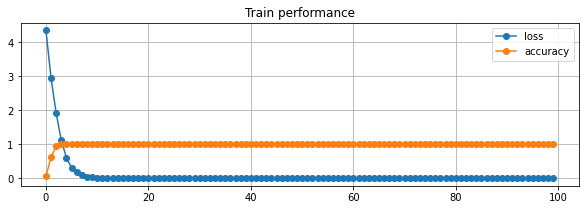

In [336]:
plt.figure(figsize=(10,3))
plt.plot(history.history["loss"], label="loss", marker="o")
plt.plot(history.history["accuracy"], label="accuracy", marker="o")
plt.grid()
plt.legend()
plt.title("Train performance")

In [337]:
preds_train = model.predict(X_train_ri).argmax(axis=1)
test_preds = model.predict(X_test_ri).argmax(axis=1)
test_preds.shape, y_test
Accuracy_train = np.mean(preds_train == y_train)
Accuracy_test = np.mean(test_preds == y_test)
print('Train Accuracy = ', Accuracy_train*100, '%')
print('Test Accuracy = ', Accuracy_test*100, '%')

Train Accuracy =  100.0 %
Test Accuracy =  36.36363636363637 %


In [0]:
# get out species from dictionary to a list
species_list=[]
for key in species.keys():
  species_list.append(key)
species_list=np.array(species_list)
objects = (species_list)

## Confusion_matrix



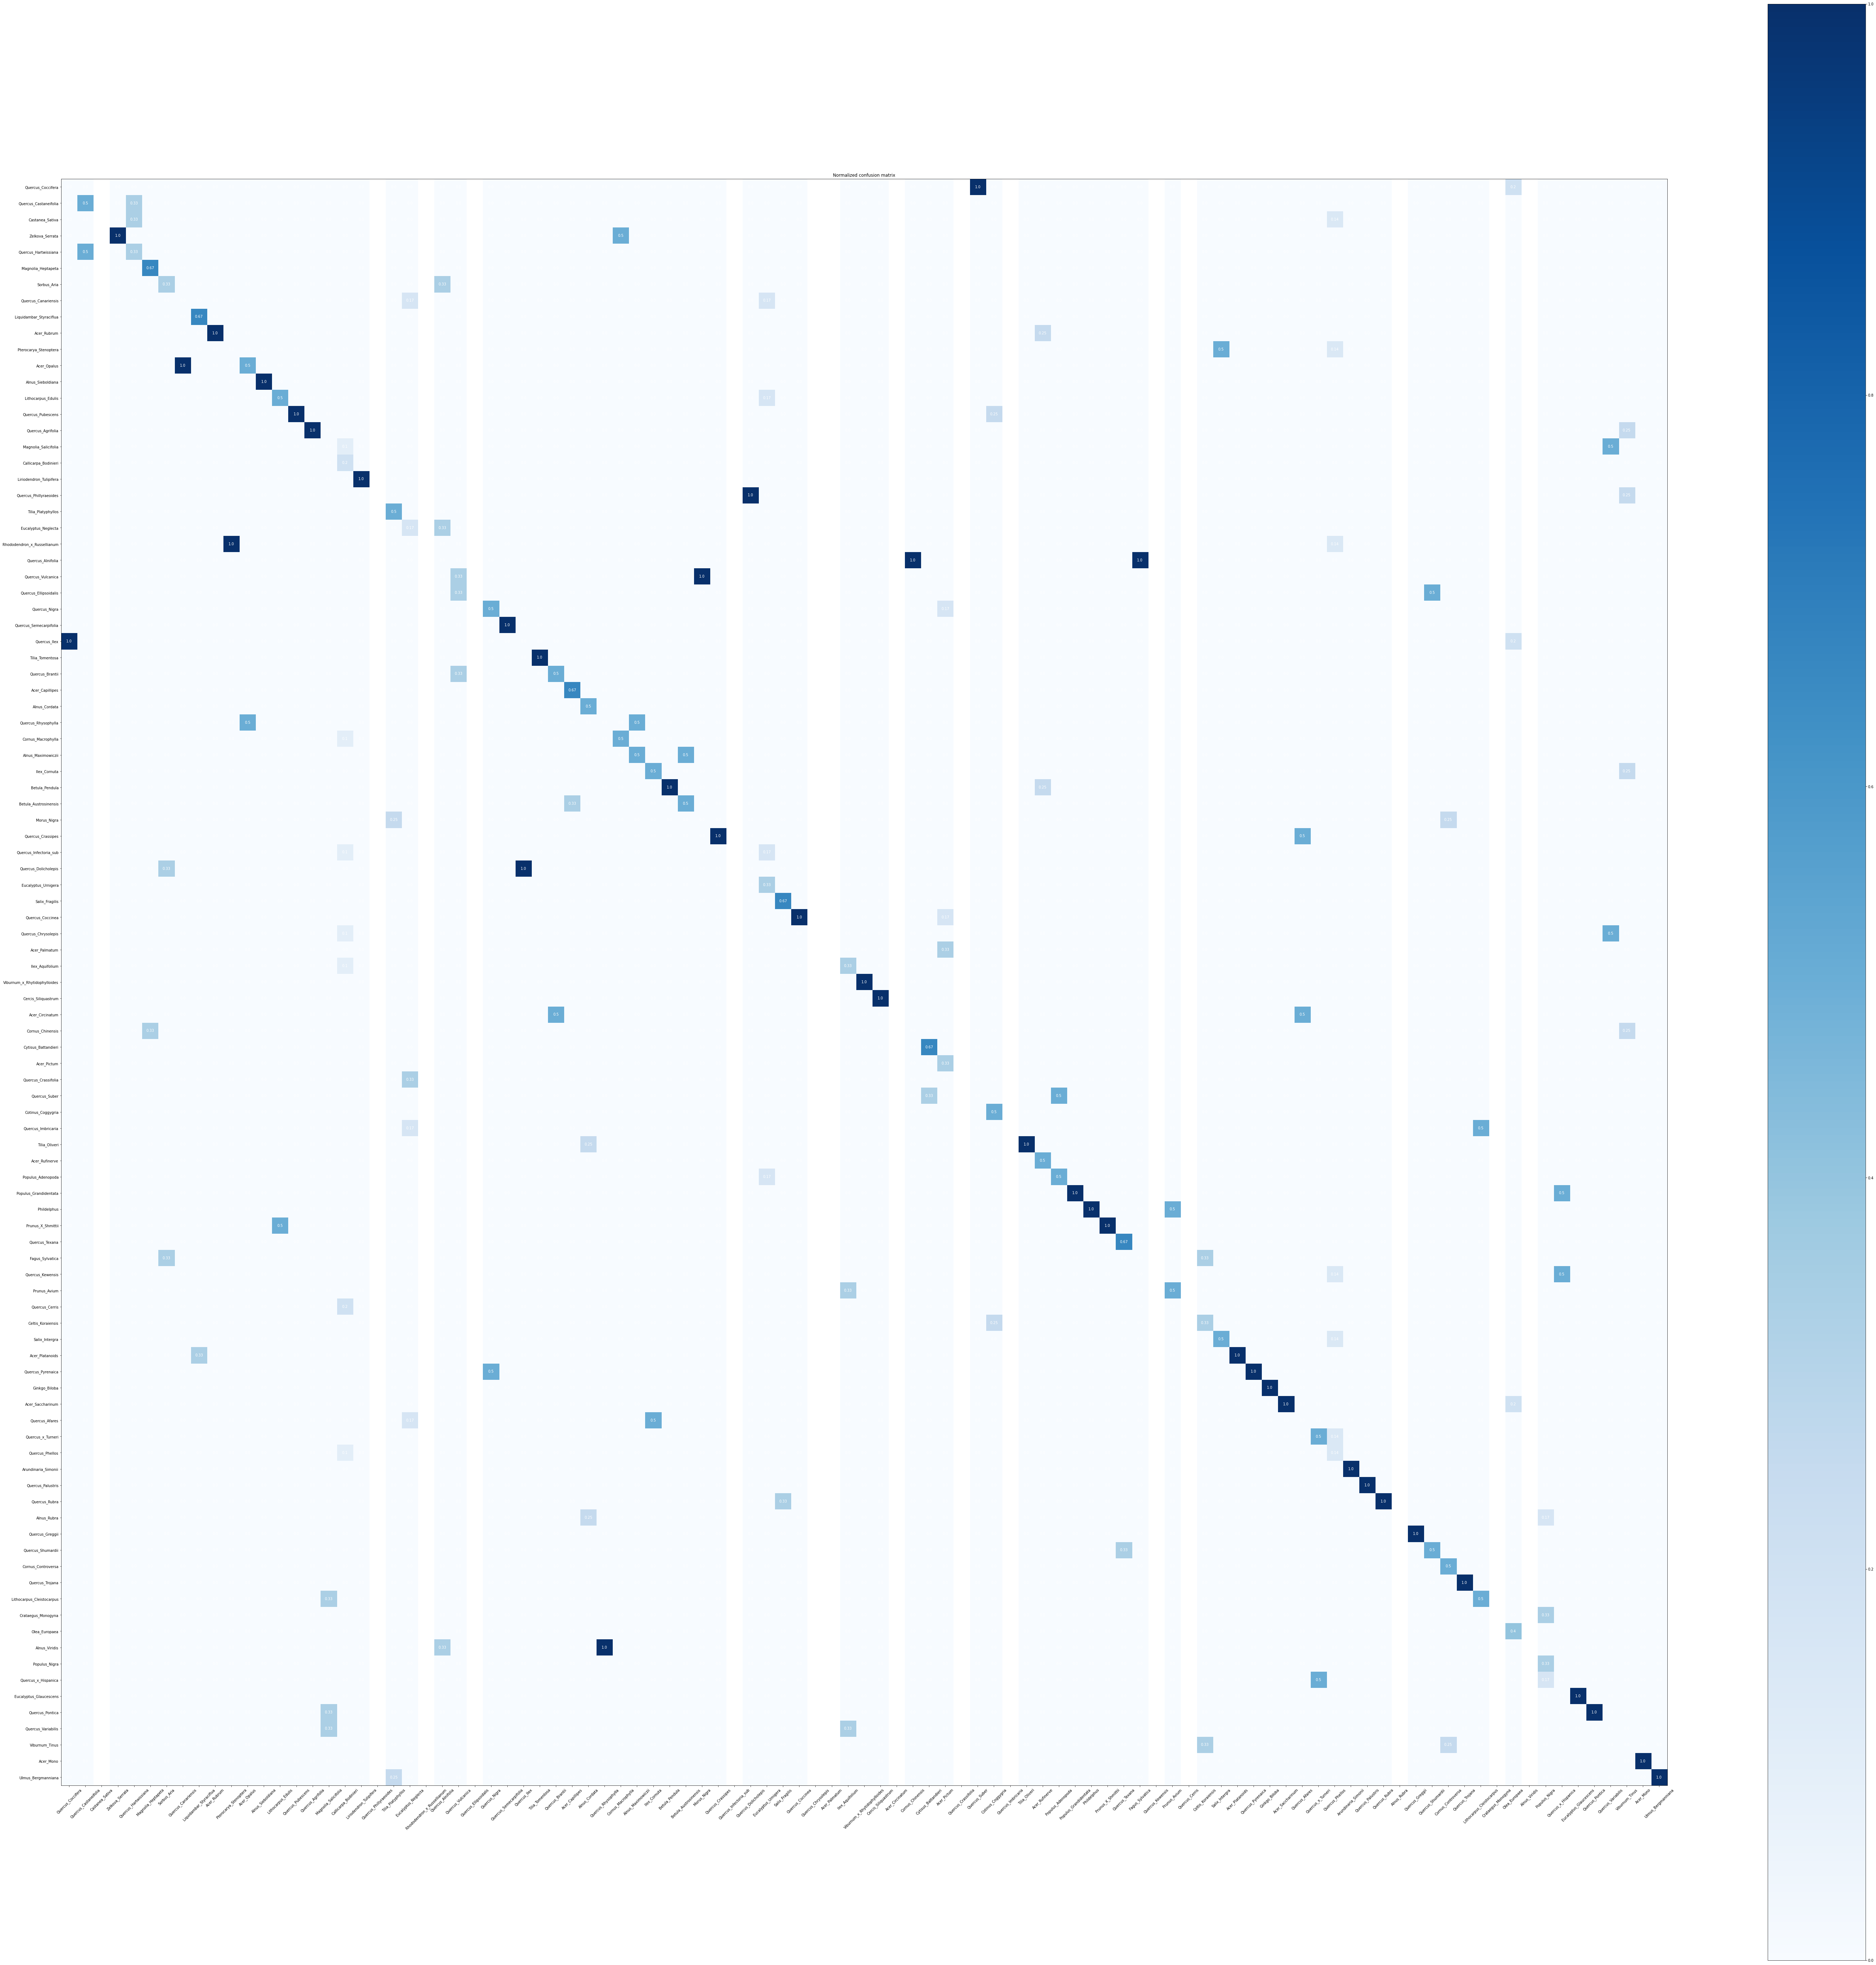

In [179]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, test_preds)
cm = cm/np.sum(cm,axis=0)
cmap = plt.cm.Blues
tick_marks = np.arange(num_classes)
fig, ax = plt.subplots(figsize=(100,100))
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = ax.text(j, i, np.around(cm[i, j],decimals=2),
                       ha="center", va="center", color="w")
plt.title('Normalized confusion matrix')
fig.colorbar(im)
plt.xticks(tick_marks, objects, rotation=45)
plt.yticks(tick_marks, objects);

# Second model with Dropout

In [0]:
def get_conv_model_B(num_classes, img_size=32, compile=True):
    print("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,1), name="input_1")
    layers = tf.keras.layers.Conv2D(4,(3,3), activation="relu")(inputs) 
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(100, activation=tf.nn.relu)(layers)#change number of neurons of dense layer
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dense(100, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='RMSprop',loss='categorical_crossentropy' ,metrics=['accuracy'] )
    return model

In [342]:
#instantiate the model
#del model
num_classes = len( y_test_oh[1])
model1 = get_conv_model_B(num_classes,img_size=128)
model1.summary()

using 99 classes
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 4)       40        
_________________________________________________________________
batch_normalization_4 (Batch (None, 126, 126, 4)       16        
_________________________________________________________________
flatten_2 (Flatten)          (None, 63504)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               6350500   
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)               400       
_________________________________________________________________
dense_5 (Dense)              (None, 100)  

Train second model


In [0]:
model1.reset_states()
history = model1.fit(X_train_ri.astype(np.float32), y_train_oh.astype(int), epochs=epochs, batch_size=batch_size, validation_data=( X_test_ri, y_test_oh))#, callbacks=[tensorboard]
metrics = model1.evaluate( X_test_ri.astype(np.float32), y_test_oh.astype(int))

Text(0.5, 1.0, 'Train performance')

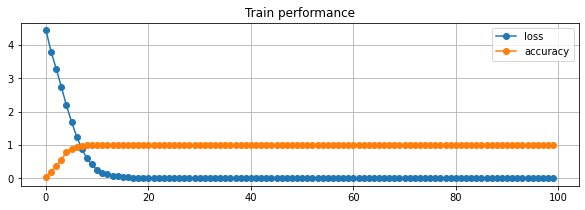

In [346]:
plt.figure(figsize=(10,3))
plt.plot(history.history["loss"], label="loss", marker="o")
plt.plot(history.history["accuracy"], label="accuracy", marker="o")
plt.grid()
plt.legend()
plt.title("Train performance")

## Acurracy second model

In [347]:

preds_train = model1.predict(X_train_ri).argmax(axis=1)
test_preds = model1.predict(X_test_ri).argmax(axis=1)
test_preds.shape, y_test
Accuracy_train = np.mean(preds_train == y_train)
Accuracy_test = np.mean(test_preds == y_test)
print('Train Accuracy = ', Accuracy_train*100, '%')
print('Test Accuracy = ', Accuracy_test*100, '%')

# test_preds = model1.predict(X_test_ri).argmax(axis=1)
# test_preds.shape, y_test
# Accuracy = np.mean(test_preds == y_test)
# print('Accuracy = ', Accuracy*100, '%')

Train Accuracy =  100.0 %
Test Accuracy =  36.7003367003367 %


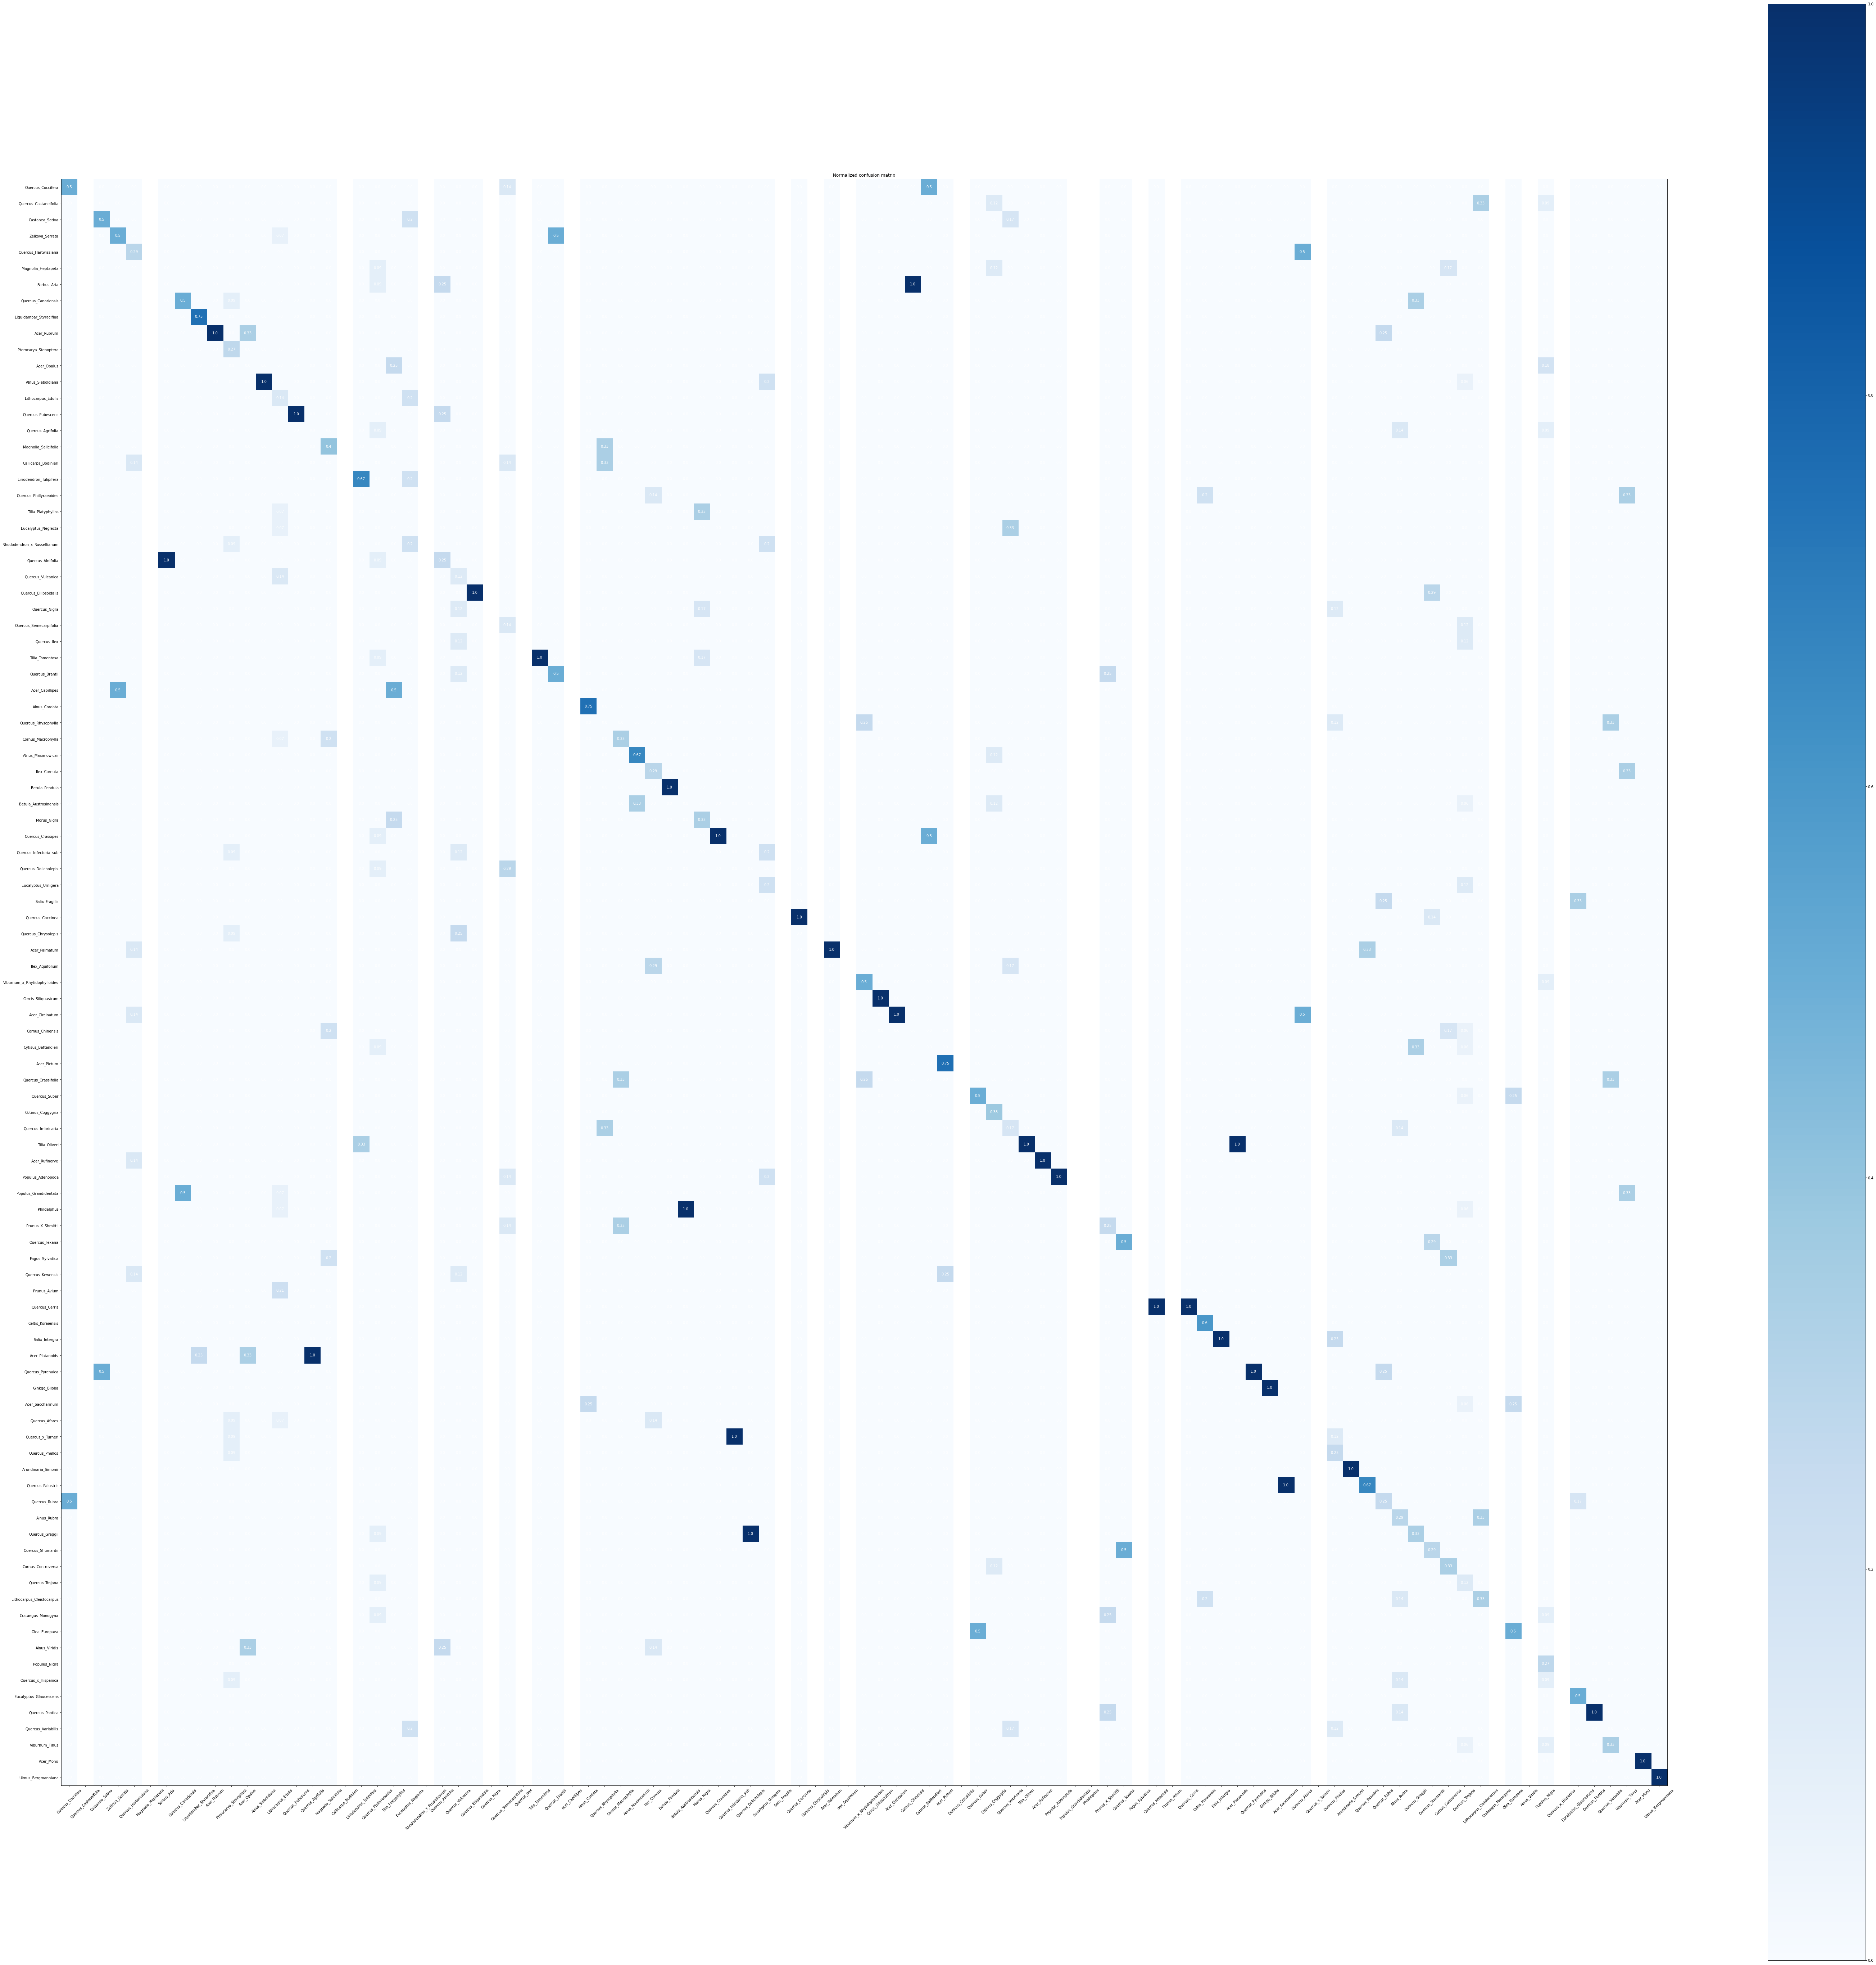

In [348]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, test_preds)
cm = cm/np.sum(cm,axis=0)
cmap = plt.cm.Blues
tick_marks = np.arange(num_classes)
fig, ax = plt.subplots(figsize=(100,100))
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = ax.text(j, i, np.around(cm[i, j],decimals=2),
                       ha="center", va="center", color="w")
plt.title('Normalized confusion matrix')
fig.colorbar(im)
plt.xticks(tick_marks, objects, rotation=45)
plt.yticks(tick_marks, objects);